In [2]:
from tsai.all import *
my_setup()

os              : Windows-10-10.0.26100-SP0
python          : 3.10.0
tsai            : 0.4.0
fastai          : 2.7.19
fastcore        : 1.7.29
torch           : 2.5.1+cpu
device          : cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.86 GB
GPU memory      : [6.0] GB


In [3]:
full_tgt_dir = "./data/tsai"
STRIDE = None
HORIZON = 1
window_length = 100
target_dir = full_tgt_dir
train_file = "./data/HouseholdPowerConsumption1_TRAIN_dim0.csv"
test_file = "./data/HouseholdPowerConsumption1_TEST_dim0.csv"
generate_split = True
print(train_file)

./data/HouseholdPowerConsumption1_TRAIN_dim0.csv


In [4]:
df_train = pd.read_csv(train_file, sep=",", header=None, index_col=0) # type: ignore
# df_train.fillna(df_train.median()) # type: ignore
df_test = pd.read_csv(test_file, sep=",", header=None, index_col=0) # type: ignore
# df_test.fillna(df_test.median()) # type: ignore
print(f"Dataset name: {train_file}. Dataset shape: {df_train.shape}.")
print(f"Dataset name: {test_file}. Dataset shape: {df_test.shape}.")
try:
    X_train, y_train = SlidingWindow(window_length, horizon=HORIZON, stride=STRIDE)(df_train)
    print(f"X train shape {X_train.shape}, y train shape {y_train.shape}")
    X_test, y_test = SlidingWindow(window_length, horizon=HORIZON, stride=STRIDE)(df_test)
    print(f"X test shape {X_test.shape}, y test shape {y_test.shape}")
except Exception as e:
    print(f"Could not generate X, y pair from Pandas dataframe: {e}")
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
print(X.shape)
print(y.shape)
print(y[:10])

Dataset name: ./data/HouseholdPowerConsumption1_TRAIN_dim0.csv. Dataset shape: (1072800, 1).
Dataset name: ./data/HouseholdPowerConsumption1_TEST_dim0.csv. Dataset shape: (987840, 1).
X train shape (10727, 1, 100), y train shape (10727,)
X test shape (9878, 1, 100), y test shape (9878,)
(20605, 1, 100)
(20605,)
[241.92 243.27 243.14 244.35 241.86 238.03 237.94 240.48 243.11 237.75]


X      - shape: [20605 samples x 1 features x 100 timesteps]  type: ndarray  dtype:float64  isnan: 13019
y      - shape: (20605,)  type: ndarray  dtype:float64  isnan: 131
splits - n_splits: 2 shape: [10727, 9878]  overlap: False


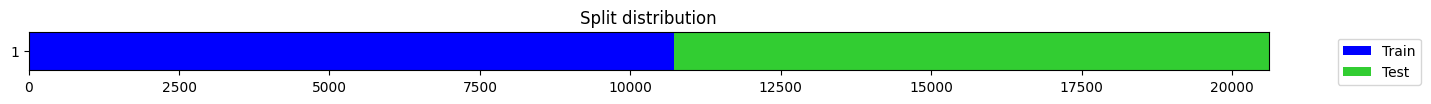

In [5]:
check_data(X, y, splits)

In [ ]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:128, vars:1, len:100, device=cpu, dtype=torch.float32),
 tensor([237.1700, 243.8800, 241.8700, 241.2900, 238.7800, 236.4800, 238.1300,
         239.2900, 242.4500, 240.0400, 241.3000, 240.4900, 242.5500, 240.9300,
         242.7400, 238.8700, 240.2200, 239.1000, 238.0300, 238.3200, 237.8500,
         240.6200, 241.7800, 241.5200, 242.2800, 242.3100, 239.7300, 243.1400,
         238.4000, 241.9500, 240.4100, 237.0200, 240.3200, 239.8000, 243.0700,
         243.2200,      nan, 241.6600, 241.1400, 240.6400, 237.6800, 240.7100,
         240.4900, 237.6000, 241.5300, 241.6400, 238.7900, 243.7400, 235.5100,
         239.2300, 244.1000, 239.1900, 239.8200, 246.7600, 240.9200, 238.6900,
         240.8600, 242.3800, 241.3000, 244.0900, 233.9200, 243.2800, 234.3800,
         245.2900, 242.0000, 241.0900, 239.3000, 241.4500, 245.9100, 233.4400,
         238.6600, 239.1900, 235.4400, 238.6200, 240.2700, 242.7200, 243.6700,
         246.1900, 242.0700, 243.0600, 236.5100, 242.2500

dls.c 1
None


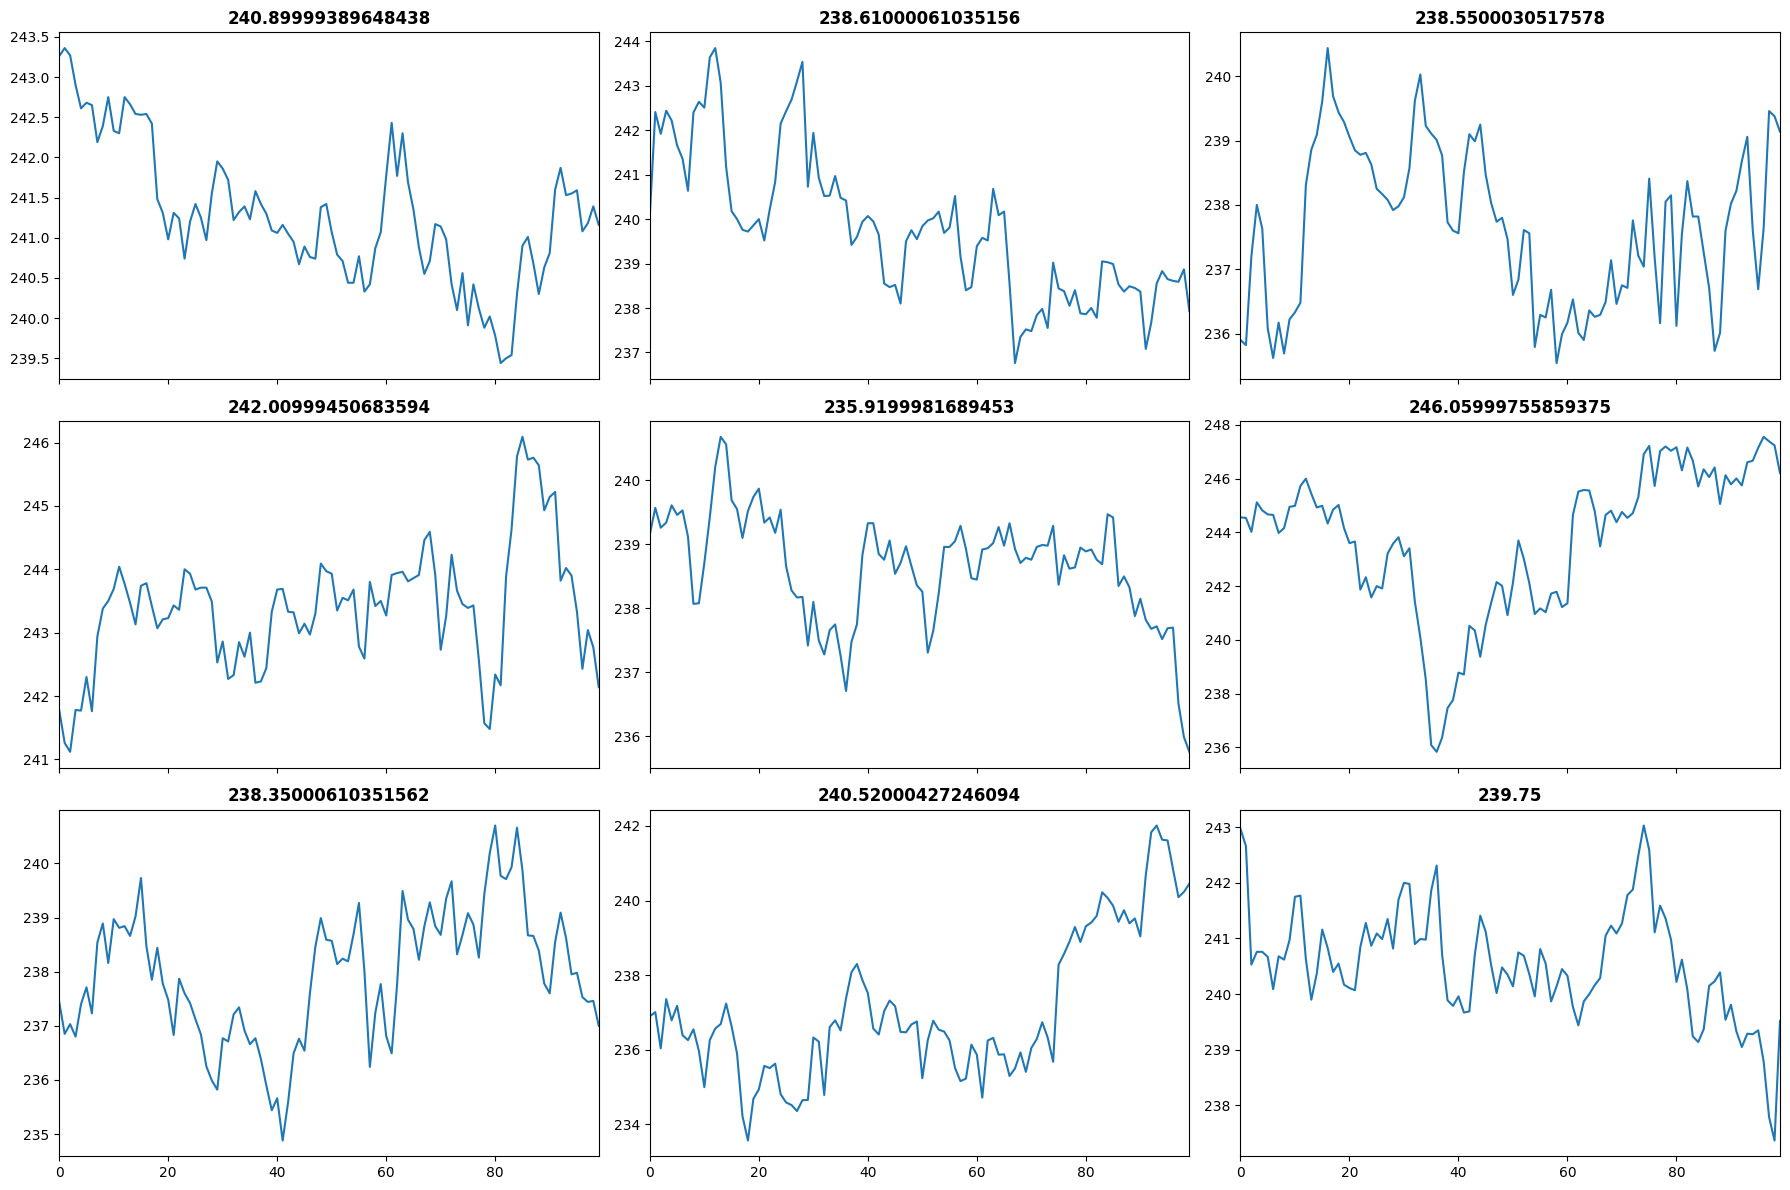

In [11]:
print(f"dls.c {dls.c}")
print(dls.show_batch())

In [12]:
learn = ts_learner(dls=dls, arch=MLP, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

0
tensor([])
tensor([])


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
learn.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,mae,_rmse,time
0,213.412460,201.435379,13.768963,14.192793,00:00
1,210.425690,201.087234,13.756340,14.180523,00:00
2,207.322433,200.221329,13.725137,14.149959,00:00
3,203.626389,198.284256,13.655792,14.081345,00:00
4,199.274979,193.780441,13.495974,13.920505,00:00
5,194.410645,182.322311,13.082893,13.502678,00:00
6,189.240692,152.703751,11.995309,12.357336,00:00
7,184.005325,131.228241,11.076872,11.455489,00:00
8,178.689056,35.500824,5.062233,5.958257,00:00
9,173.157150,42.804482,5.805856,6.542513,00:00


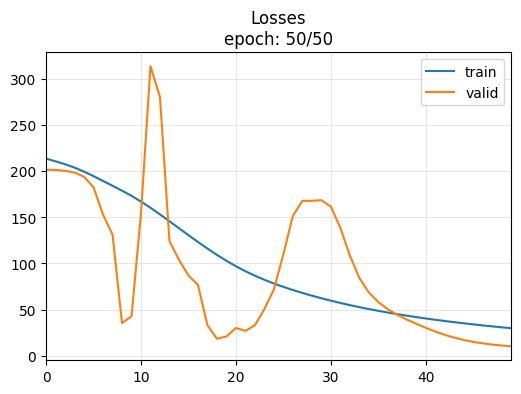

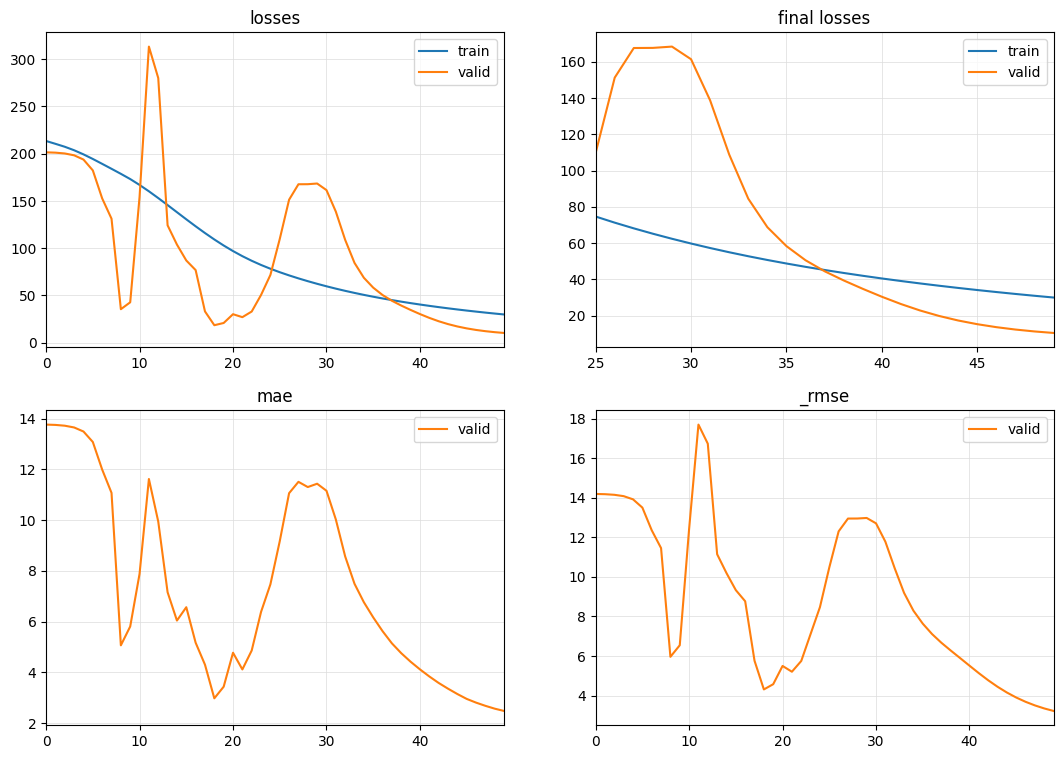

In [ ]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(50, 1e-2)

In [ ]:
PATH = Path('./models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)
del learn

In [ ]:
PATH = Path('./models/Regression.pkl')
learn = load_learner(PATH, cpu=False)

In [ ]:
probas, _, preds = learn.get_X_preds(X[splits[1]])
skm.root_mean_squared_error(y[splits[1]], preds)

3.220502099774406